In [1]:
import json
from uuid import uuid4
from collections import Counter

import pandas as pd
from tqdm import tqdm
import numpy as np
from datasets import load_dataset
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
import optuna
import shap
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, f1_score

from imblearn.over_sampling import RandomOverSampler

from transformers import AutoTokenizer, AutoModelForTokenClassification
from transformers import pipeline

import pickle


In [2]:
results_df = pd.read_csv('data/ner_deep_learning_results.csv')
mistakes = results_df[(results_df['y_pred'] == 0) & (results_df.model == 'dslim/bert-base-NER')]['Name'].to_numpy()
mistakes
rng = np.random.default_rng(seed=0)
hard_name = rng.choice(mistakes)
print(hard_name)
switch_name = 'Peter'
targets = ['no emotion', 'anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise']


Riku


# NER False Negatives

array(['A', 'A', 'A', ..., 'Zion', 'Zion', 'Zion'], dtype=object)

# feature importance

In [3]:
model_name='dslim/bert-base-NER'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForTokenClassification.from_pretrained(model_name)



def train(who='all', n_samples=100, fp='data/output.pkl'):
    """
    who: 'all' - anonyimise everyone
    who: 'rare-once' - only insert the rare name once
    """

    removed_names = set()

    def anonymise(sentence, who='all'):
        global rare_insert_count
        nlp = pipeline("ner", model=model, tokenizer=tokenizer)
        ner_results = nlp(sentence)
        for item in ner_results:
            # https://huggingface.co/dslim/bert-base-NER
            if item['entity'] in ['B-PER', 'I-PER']:
                # Assume that there rare name IS in the dataset. We replace another name with hard name.
                if who == 'all':
                    if item['word'] == switch_name:
                        sentence = sentence.replace(item['word'], hard_name)
                        print(sentence)
                    else:
                        sentence = sentence.replace(item['word'], '')
                        removed_names.add(item['word'])

                elif who == 'rare_once':
                    if item['word'] == switch_name and rare_insert_count < 1:
                        sentence = sentence.replace(item['word'], hard_name)
                        print(sentence)
                        rare_insert_count += 1
                    else:
                        sentence = sentence.replace(item['word'], '')
                        removed_names.add(item['word'])
                elif who == 'noone':
                    if item['word'] == switch_name:
                        sentence = sentence.replace(item['word'], hard_name)
                        print(sentence)
                else:
                    raise NotImplementedError(f'{who} is an unknown option')

        return sentence

    def process(split='train', ner=True):    
    
        utterance = []
        ids = []
        label = []
        act = []
        
        # Apply the function to all examples in the dataset
        dataset = load_dataset('daily_dialog', split=split)
        
        if n_samples:
            nd = n_samples
        else:
            nd = len(dataset)
        
        for i in tqdm(range(nd)):
            example = dataset[i]
            did = uuid4()
            for j in range(len(example['dialog'])):
                text = example['dialog'][j]
                # add previous sentnce xontext
                if j > 1:
                    text = str(example['emotion'][j - 1]) + ' ' + example['dialog'][j - 1] + ' ' + text
                if ner:
                    text = anonymise(text, who=who)
                utterance.append(text)
                act.append(example['act'][j])
                label.append(example['emotion'][j])
                ids.append(did)

        data = {
            'text': utterance,
            'label': label,
            'attr': act,
            'id': ids
        }

        df = pd.DataFrame(data=data)

        return df
    
    global rare_insert_count
    rare_insert_count = 0
    df_train = process(split='train')
    print('n train', len(df_train))
    rare_insert_count = 0
    df_valid = process(split='validation')
    rare_insert_count = 0
    df_test = process(split='test')

    print(list(set(removed_names)))

    # improves macro f1
    rus = RandomOverSampler(random_state=42)
    df_train, _ = rus.fit_resample(df_train, df_train.label)

    counts = Counter(df_train.label)
    print('train label dist.', counts)

    clf = SGDClassifier(loss='log_loss', penalty='l2', alpha=1.0930076764057076e-05, n_jobs=-1)
    vec = TfidfVectorizer()

    X_train_tfidf = vec.fit_transform(df_train.text.to_list())
    X_valid_tfidf = vec.transform(df_valid.text.to_list())
    X_test_tfidf = vec.transform(df_test.text.to_list())

    clf.fit(X_train_tfidf, df_train.label)

    y_pred = clf.predict(X_test_tfidf)
    y_true = df_test.label
    report = classification_report(y_true, y_pred)
    print(report)

    r = (clf, vec, removed_names, X_train_tfidf, df_train, X_test_tfidf, df_test)

    f = open(fp, 'wb')
    pickle.dump(r, f)
    f.close()

    return r


In [4]:
#r_all = train(who='all', n_samples=None, fp='data/all.pkl') # anonymise everyone
r_noone = train(who='noone', n_samples=None, fp='data/all.pkl') # anonymise everyone


Found cached dataset daily_dialog (/home/john/.cache/huggingface/datasets/daily_dialog/default/1.0.0/1d0a58c7f2a4dab5ed9d01dbde8e55e0058e589ab81fce5c2df929ea810eabcd)
  0%|          | 40/11118 [00:10<46:47,  3.95it/s]  

 Great idea ! Riku , I could use the drink . 
4  Great idea ! Riku , I could use the drink .   How about the new bar across road ? 


  3%|▎         | 319/11118 [01:21<45:52,  3.92it/s]  

Did you hear Riku just retired ? 


  4%|▍         | 442/11118 [01:49<39:26,  4.51it/s]  

Who broke the glass , Riku ? 


  4%|▍         | 468/11118 [01:59<1:17:21,  2.29it/s]

0  Well , so long , Mary . Have fun .   You too , Riku . Give my regards to John . I'll see you in September . 


  5%|▍         | 521/11118 [02:13<29:48,  5.92it/s]  

Riku and Mary broke up . 


  6%|▌         | 654/11118 [02:51<35:50,  4.86it/s]  

 Great idea ! Riku , I could use the drink . 
4  Great idea ! Riku , I could use the drink .   How about the new bar across road ? 


 10%|▉         | 1077/11118 [04:37<48:39,  3.44it/s] 

0  Who's coming ?   Riku.Riku Brown , you know.Don ' t forget to bring the letter . 
0  Who's coming ?   Riku.Riku Brown , you know.Don ' t forget to bring the letter . 
0  Riku.Riku Brown , you know.Don ' t forget to bring the letter .   Sorry . I didn't quite catch what you said.There ' s a lot of noise outside . 
0  Riku.Riku Brown , you know.Don ' t forget to bring the letter .   Sorry . I didn't quite catch what you said.There ' s a lot of noise outside . 


 18%|█▊        | 1967/11118 [08:58<45:53,  3.32it/s]  

0  All right .   Riku ! Pack them . Don't read them . 


 19%|█▉        | 2110/11118 [09:29<37:33,  4.00it/s]

4  I think you can say your seventh great grandfather ! Cutie ! What's his name ?   Riku Madsen . A great A if I do say so myself . 
0  Riku Madsen . A great A if I do say so myself .   Nice pun . What is it you active about him most ? 


 19%|█▉        | 2132/11118 [09:34<36:21,  4.12it/s]

 Thank you , Riku . Come into the dining room . We are going to cut the cake soon . 
4  Thank you , Riku . Come into the dining room . We are going to cut the cake soon .   Ok , who is that girl ? 


 20%|█▉        | 2203/11118 [09:51<34:00,  4.37it/s]  

Hi , Riku . I ’ m afraid I can ’ t make it to dinner tomorrow night . 


 21%|██        | 2359/11118 [10:33<30:12,  4.83it/s]  

Riku is a bag lady now . 


 24%|██▍       | 2676/11118 [12:01<34:54,  4.03it/s]  

What is wrong with Riku ? He sure looks unhappy . 


 24%|██▍       | 2678/11118 [12:01<27:57,  5.03it/s]

Riku , which club do you want to join ? 


 27%|██▋       | 2989/11118 [13:35<41:23,  3.27it/s]  

Hi ! Riku . How are you ? 


 27%|██▋       | 2995/11118 [13:37<53:34,  2.53it/s]  

 Hi , Riku . I didn't see you last night . Where did you go ? 
0  Hi , Riku . I didn't see you last night . Where did you go ?   I was almost on line the whole night . 


 29%|██▉       | 3267/11118 [14:55<39:17,  3.33it/s]  

 Thank you , Riku . 
4  Thank you , Riku .   Oh , let's come in and enjoy yourself . 
4  Oh , let's come in and enjoy yourself .   Happy birthday , Riku , and many happy returns of the day . Here's a present for you . 
4  Happy birthday , Riku , and many happy returns of the day . Here's a present for you .   Thank you , Li Mei . Come into the dining room . I'm going to cut the cake soon . 


 30%|██▉       | 3292/11118 [15:02<48:04,  2.71it/s]

Riku really is a remarkable expert ! There is very little he doesn ’ t know . 


 31%|███       | 3459/11118 [15:54<52:12,  2.45it/s]  

Riku , have you finished your English composition ? 


 31%|███▏      | 3496/11118 [16:05<29:16,  4.34it/s]

 Nice to see you again , too . Riku . How's your family ? 
0  Nice to see you again , too . Riku . How's your family ?   Very well . How's Mrs . Clinton ? 


 36%|███▋      | 4038/11118 [18:30<32:43,  3.61it/s]  

0  Oh ! I forgot all about it . Of course you can have it back , John . I'm sorry about the delay .   Well , it doesn't matter . I almost forgot it too if it is not for Riku who asked me about it this coming . 


 37%|███▋      | 4076/11118 [18:41<36:27,  3.22it/s]

So Riku , do you have a favorite comedy ? 


 41%|████      | 4572/11118 [20:59<33:03,  3.30it/s]  

0  OK , I suppose , but she's had a rough time in the last few years , She got divorced .   What , from Riku ? 
0  What , from Riku ?   Oh , of course . 


 43%|████▎     | 4807/11118 [21:58<30:15,  3.48it/s]

Well , Riku , you have to do better than that next time , won ’ t you ? 


 43%|████▎     | 4828/11118 [22:04<42:02,  2.49it/s]

Well , Riku . I'm sorry you're ill . What's the matter with you ? 


 44%|████▍     | 4903/11118 [22:25<31:42,  3.27it/s]

Well , Riku , you have to do better than that next time , won't you ? 


 44%|████▍     | 4917/11118 [22:30<31:19,  3.30it/s]

0  Did someone get hurt ?   A driver died instantly . The other one was badly hurt . A poor boy called Riku was killed in the accident too . 
0  A driver died instantly . The other one was badly hurt . A poor boy called Riku was killed in the accident too .   What a terrible accident ! Who should be responsible for this traffic accident ? 


 45%|████▍     | 4978/11118 [22:47<31:55,  3.20it/s]

Hello , I'm sorry for calling this late . May I speak to Riku ? 


 45%|████▌     | 5050/11118 [23:10<26:06,  3.87it/s]

Take care , Riku . Don't run so fast.Are you tired ? 


 46%|████▌     | 5114/11118 [23:31<24:31,  4.08it/s]

Look , who's here , Riku ! 


 48%|████▊     | 5318/11118 [24:33<24:34,  3.93it/s]

 It's Riku's turn . 
0  It's Riku's turn .   Give the mike to him . 


 52%|█████▏    | 5757/11118 [26:31<20:09,  4.43it/s]

0  Good morning ! Welcome to our office !   Nice to meet you ! My name is Riku Smith . 
0  Nice to meet you ! My name is Riku Smith .   Nice to meet you too ! I am George Williams . 


 55%|█████▌    | 6123/11118 [28:09<17:51,  4.66it/s]

Riku , I hope you will accept my quotation for the air freshener . 


 55%|█████▌    | 6124/11118 [28:09<20:29,  4.06it/s]

0  Then , I am sorry to say I must regretfully decline your offer and seek quotations for the other suppliers .   I'm sorry , Riku . I hope you'll continue to approach us on other occasions if you cannot accept our offer now . 
0  I'm sorry , Riku . I hope you'll continue to approach us on other occasions if you cannot accept our offer now .   Yes . I'll welcome other opportunities to do business with you . 


 55%|█████▌    | 6147/11118 [28:14<17:04,  4.85it/s]

Riku , listen to the lyrics of this song . 


 59%|█████▉    | 6603/11118 [30:25<21:43,  3.46it/s]

Welcome home , Riku ! 


 61%|██████    | 6775/11118 [31:14<14:51,  4.87it/s]

Riku ? This is Steven from China . I've got the document you want . 


 61%|██████    | 6805/11118 [31:21<16:16,  4.42it/s]

 What happened , Riku ? Did you have a fight ? 
0  What happened , Riku ? Did you have a fight ?   No , mom . I didn't . 


 63%|██████▎   | 7028/11118 [32:25<14:19,  4.76it/s]

Hello , this is Riku Dixon from NEZ news radio . May I speak to Mr . Wilson please ? 


 63%|██████▎   | 7042/11118 [32:28<19:57,  3.40it/s]

0  Put it in the waste-paper basket , please .   But Riku and Tony put all their paper in the basket a few moments ago.Now it's full . 
0  But Riku and Tony put all their paper in the basket a few moments ago.Now it's full .   In that case , take the basket outside and empty it . 


 65%|██████▍   | 7185/11118 [33:07<24:23,  2.69it/s]

Riku , it's time to eat breakfast . 


 69%|██████▉   | 7687/11118 [35:21<18:04,  3.16it/s]

 Yes . This is Riku calling from New York , I have to change the date of reservation . 
0  Yes . This is Riku calling from New York , I have to change the date of reservation .   How and in whose name has the reservation been made ? 


 71%|███████▏  | 7936/11118 [36:30<10:27,  5.07it/s]

0  I don't know yet . What's your idea , Dad ?   I'm thinking of taking you and Riku swimming . What do you think ? 
0  I'm thinking of taking you and Riku swimming . What do you think ?   Dad ! It's cold now ! 


 73%|███████▎  | 8101/11118 [37:17<10:09,  4.95it/s]

0  It's dusty everywhere in the house . Can you help me do the housecleaning ?   OK . I will call Riku to clean it together . 
0  OK . I will call Riku to clean it together .   That's my good girl . The clothes need washing . I'll do the laundry . 


 74%|███████▎  | 8193/11118 [37:41<13:31,  3.61it/s]

0  Who's coming ?   Riku . Riku Brown , you know . Don't forget to bring the letter . 
0  Who's coming ?   Riku . Riku Brown , you know . Don't forget to bring the letter . 
0  Riku . Riku Brown , you know . Don't forget to bring the letter .   Sorry . I didn't quite catch what you said . There's a lot of noise outside . 
0  Riku . Riku Brown , you know . Don't forget to bring the letter .   Sorry . I didn't quite catch what you said . There's a lot of noise outside . 


 74%|███████▍  | 8225/11118 [37:51<15:28,  3.12it/s]

 Yes , my name is Riku . I have made a reservation for a single room from June 18th to June 21st . I'd like to make some changes . The reservation should only be to June 20th . 
0  Yes , my name is Riku . I have made a reservation for a single room from June 18th to June 21st . I'd like to make some changes . The reservation should only be to June 20th .   A single room from June 18th to 20th . Is that correct ? 


 76%|███████▌  | 8417/11118 [38:44<14:12,  3.17it/s]

4  Thank you . Also , how can I get my mailbox key ?   I ’ ll tell Riku to bring your key to your apartment right away . 
0  I ’ ll tell Riku to bring your key to your apartment right away .   Who ’ s Riku ? 
0  I ’ ll tell Riku to bring your key to your apartment right away .   Who ’ s Riku ? 
0  Who ’ s Riku ?   He ’ s the superintendent of this building . 


 77%|███████▋  | 8551/11118 [39:16<08:29,  5.04it/s]

Riku , do you want to learn to play the piano ? 


 80%|███████▉  | 8844/11118 [40:38<12:33,  3.02it/s]

Riku , wash your hands first , and then have some dessert . 


 80%|███████▉  | 8862/11118 [40:43<09:49,  3.82it/s]

 Yes , I'd like to check in , please . M y name is Riku Wang . I have a reservation for three nights . 
0  Yes , I'd like to check in , please . M y name is Riku Wang . I have a reservation for three nights .   Just a moment , please . Oh , yes . One twin and one single . Is that right ? 


 82%|████████▏ | 9153/11118 [41:51<06:28,  5.06it/s]

0  Please allow me to introduce myself . My name is Li Hua . Nice to meet you .   Nice to meet you , too . Miss Li . please have a seat . I am Riku Smith , the General Manager . 


 83%|████████▎ | 9246/11118 [42:11<06:35,  4.73it/s]

 Hi , Riku ! How are you ? 
0  Hi , Riku ! How are you ?   Fine , thanks.And you ? 


 84%|████████▍ | 9348/11118 [42:33<05:59,  4.93it/s]

0  That is your excuse .   All right , all right , I will go swimming with Riku this afternoon . 
0  All right , all right , I will go swimming with Riku this afternoon .   Not just today . Go exercise everyday ! 


 85%|████████▌ | 9456/11118 [42:57<05:57,  4.64it/s]

Riku , where are you going ? 


 86%|████████▌ | 9528/11118 [43:16<05:34,  4.75it/s]

Good evening . This is Riku in Room 310 . 


 89%|████████▉ | 9923/11118 [45:01<05:27,  3.65it/s]

Riku , it's time to go home now ! Hurry up ! 
0  I bet she will hang around with her mates after school .   Riku , it's a quarter to twelve . Let's go home now ! 


 90%|████████▉ | 10002/11118 [45:25<05:59,  3.11it/s]

Riku , why don't you go outside and play basketball with your friends ? 


 90%|████████▉ | 10003/11118 [45:25<06:08,  3.02it/s]

0  Yes , but a football game is next .   Oh , Riku . You really should go and play ball yourself rather than watching games . 
0  Oh , Riku . You really should go and play ball yourself rather than watching games .   I just enjoy watching games . 


 90%|█████████ | 10034/11118 [45:37<08:23,  2.15it/s]

May I speak to Riku ? 


 91%|█████████ | 10119/11118 [46:02<05:11,  3.21it/s]

0  OK . What name , please ?   This is Riku Kaufman . 
0  This is Riku Kaufman .   Can you spell that , please ? 
0  Can you spell that , please ?   Riku Kaufman , P-E-T-E-R ( Riku ) , K-A-U-F-M-A-N ( Kaufman ) . 
0  Can you spell that , please ?   Riku Kaufman , P-E-T-E-R ( Riku ) , K-A-U-F-M-A-N ( Kaufman ) . 
0  Riku Kaufman , P-E-T-E-R ( Riku ) , K-A-U-F-M-A-N ( Kaufman ) .   Oh , thanks , Mr . Kaufman . We look forward to your visit . 
0  Riku Kaufman , P-E-T-E-R ( Riku ) , K-A-U-F-M-A-N ( Kaufman ) .   Oh , thanks , Mr . Kaufman . We look forward to your visit . 


 91%|█████████ | 10126/11118 [46:04<04:33,  3.62it/s]

0  May I have your name , sir , please ?   Please book it under the name of Mr . Riku . 
0  Please book it under the name of Mr . Riku .   So it's Mr . Riku , a table for six for the evening of the next Monday . It is Chinese food and you are coming at 6:30 . 
0  Please book it under the name of Mr . Riku .   So it's Mr . Riku , a table for six for the evening of the next Monday . It is Chinese food and you are coming at 6:30 . 
0  So it's Mr . Riku , a table for six for the evening of the next Monday . It is Chinese food and you are coming at 6:30 .   That's right . 


 92%|█████████▏| 10243/11118 [46:36<03:24,  4.28it/s]

Riku , have you seen my purse ? 


 95%|█████████▌| 10567/11118 [48:03<01:54,  4.82it/s]

 Good morning . I'd like to speak to Riku . Chen Please . 
0  Good morning . I'd like to speak to Riku . Chen Please .   Certainly . Who should I say is calling ? 


 95%|█████████▌| 10614/11118 [48:18<01:52,  4.48it/s]

Riku , take off your pajamas . 


 97%|█████████▋| 10748/11118 [48:55<01:30,  4.10it/s]

 Ah , good morning , Mr . Smith . Nice to meet you . I'm Riku Anderson from Personnel . Do sit down . 
0  Ah , good morning , Mr . Smith . Nice to meet you . I'm Riku Anderson from Personnel . Do sit down .   Thank you very much . 


100%|██████████| 11118/11118 [50:39<00:00,  3.66it/s]


n train 87170


Found cached dataset daily_dialog (/home/john/.cache/huggingface/datasets/daily_dialog/default/1.0.0/1d0a58c7f2a4dab5ed9d01dbde8e55e0058e589ab81fce5c2df929ea810eabcd)
 25%|██▌       | 253/1000 [01:12<03:37,  3.43it/s]

 Good morning . I'd like to speak to Riku . Chen Please . 
0  Good morning . I'd like to speak to Riku . Chen Please .   Certainly . Who should I say is calling ? 


 26%|██▌       | 256/1000 [01:13<03:14,  3.82it/s]

Can ’ t you come in and have tea now , Riku ? 


 34%|███▎      | 335/1000 [01:36<02:47,  3.98it/s]

Riku , enough with your computer games . Go do your homework now . 
0  Mom , I'll be finished soon .   Riku , if you don't turn off your computer , then I won't allow you to play it again starting next week . 


 36%|███▌      | 359/1000 [01:41<02:07,  5.01it/s]

Riku , how often do you exercise ? 


 49%|████▉     | 489/1000 [02:15<01:34,  5.39it/s]

Riku , it's time to get up . 


 67%|██████▋   | 668/1000 [03:03<01:39,  3.33it/s]

0  Oh , honey , I'm so sorry , we don't have enough space for you to have your own room .   Dad , but I don't want to share a room with Riku . He snores every night . 
5  Dad , but I don't want to share a room with Riku . He snores every night .   Honey , you can ask him to be quite . Otherwise you may punish him and tell him to stand out of the room , right ? 


 82%|████████▏ | 819/1000 [03:48<01:15,  2.38it/s]

Well , Riku , you have to do better than that next time , won ’ t you ? 


 84%|████████▍ | 839/1000 [03:55<00:55,  2.92it/s]

Medicine Industry , this is Riku Bush speaking , can I help you ? 


 95%|█████████▍| 947/1000 [04:33<00:16,  3.17it/s]

Riku , go and tidy up your toys now . 
0  Mom , just ten more minutes . The show is going to be over soon .   Riku , if you don't do it soon , I will throw your toys in the trash can . 


 95%|█████████▌| 953/1000 [04:36<00:18,  2.58it/s]

Take care , Riku . Don't run so fast . Are you tired ? 


100%|██████████| 1000/1000 [04:51<00:00,  3.43it/s]
Found cached dataset daily_dialog (/home/john/.cache/huggingface/datasets/daily_dialog/default/1.0.0/1d0a58c7f2a4dab5ed9d01dbde8e55e0058e589ab81fce5c2df929ea810eabcd)
 24%|██▎       | 236/1000 [01:03<03:55,  3.25it/s]

 Yes , please . I ’ m Mr . Riku , the Director of Personnel . What can I do for you ? 
0  Yes , please . I ’ m Mr . Riku , the Director of Personnel . What can I do for you ?   Nice to meet you , Mr . Riku . I ’ m Wang Sian . I ’ Ve come for an interview as requested . 
0  Yes , please . I ’ m Mr . Riku , the Director of Personnel . What can I do for you ?   Nice to meet you , Mr . Riku . I ’ m Wang Sian . I ’ Ve come for an interview as requested . 
0  Nice to meet you , Mr . Riku . I ’ m Wang Sian . I ’ Ve come for an interview as requested .   Oh , yes . How do you do , Miss Wang ? Sit down , please . 


 42%|████▏     | 419/1000 [02:06<03:50,  2.52it/s]

 Four is an unlucky number here , Riku.Four sounds like death in Chinese.Hotels often have no fourth floor . 
0  Four is an unlucky number here , Riku.Four sounds like death in Chinese.Hotels often have no fourth floor .   I see.Oh , I know what I wanted to ask.How much should I tip this guy ? 


 60%|█████▉    | 599/1000 [03:00<02:11,  3.05it/s]

4  Nice to meet you ! My name is Grace Williams .   Nice to meet you too ! I am Riku Smith . 
4  Nice to meet you too ! I am Riku Smith .   Today is my first day at work ! 


 71%|███████▏  | 713/1000 [03:34<00:49,  5.85it/s]

Morning , Riku . Nice suit ! A new one ? 


 74%|███████▍  | 744/1000 [03:42<01:04,  3.94it/s]

 Great idea ! Riku , I could use the drink . 
4  Great idea ! Riku , I could use the drink .   How about the new bar across the road ? 


 75%|███████▍  | 747/1000 [03:44<01:40,  2.51it/s]

0  Well , I thought that maybe we could go there for lunch today . That is , if you haven't promised to go with someone else .   That'd be wonderful , Riku . But I hope you're in a better mood than you were this morning . 
4  That'd be wonderful , Riku . But I hope you're in a better mood than you were this morning .   I'm sorry I was such a grouch . It must've been the weather . When it rains I get depressed . 


 79%|███████▉  | 788/1000 [03:54<00:56,  3.76it/s]

0  How do you know that ?   She told me that Riku and she has a quarrel last nigh , and she left this morning , bag and baggage . 
0  She told me that Riku and she has a quarrel last nigh , and she left this morning , bag and baggage .   Oh , I see . But I think you are making a fuss . They will make it up . Bet it . 


 87%|████████▋ | 870/1000 [04:19<00:28,  4.55it/s]

Hey , Riku , have you had lunch yet ? 


 92%|█████████▏| 915/1000 [04:31<00:21,  4.02it/s]

Riku , how often do you exercise ? 


 96%|█████████▌| 962/1000 [04:43<00:07,  5.02it/s]

 Nice to see you again , too . Riku . How's your family ? 
0  Nice to see you again , too . Riku . How's your family ?   A :: Very well . How's Mrs Clinton ? 


 97%|█████████▋| 971/1000 [04:45<00:09,  3.14it/s]

Riku , how often do you exercise ? 


100%|██████████| 1000/1000 [04:52<00:00,  3.42it/s]


[]
train label dist. Counter({0: 72143, 4: 72143, 6: 72143, 3: 72143, 2: 72143, 5: 72143, 1: 72143})
              precision    recall  f1-score   support

           0       0.93      0.61      0.74      6321
           1       0.14      0.52      0.22       118
           2       0.12      0.40      0.19        47
           3       0.13      0.53      0.20        17
           4       0.41      0.66      0.50      1019
           5       0.10      0.59      0.18       102
           6       0.09      0.53      0.15       116

    accuracy                           0.61      7740
   macro avg       0.27      0.55      0.31      7740
weighted avg       0.82      0.61      0.68      7740



# Evaluate label flipping

In [7]:
from scipy.stats import entropy
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from styles import fig_size

sns.set_style('white')
sns.set_context('paper')
sns.set_palette('tab10')

def evaluate(fp, num_sentence, num_preds, test_name):

    f = open(fp, 'rb')
    clf, vec, removed_names, X_train_tfidf, df_train, X_test_tfidf, df_test = pickle.load(f)
    f.close()

    explainer = shap.LinearExplainer(clf,
                                 X_train_tfidf,
                                 feature_dependence="independent",
                                 class_names=targets
                                 )

    probs  = clf.predict_proba(X_test_tfidf)

    # sort predictions by entropy descending order
    u = entropy(probs, axis=1)
    u_indx = np.argsort(u)[::-1]
    u_text = df_test.text.to_numpy()[u_indx]

    # print top 5 most informative predictions
    print(u_text[:5])

    # Names which NER removed but are not names
    blacklist = [
        'Mr',
        'Call',
        'Long',
        'My',
        'Car',
        'He',
        'Mum',
        'Black',
        'Drive',
        'White',
        'Ma',
        'Z',
        'B',
        'Sun',
        '.',
        'Mad',
        'Mon',
        'Cat',
        'Ball',
        'Hell',
        'Sounds',
        'Shut',
        'Aunt',
        'Rich',
        'Map',
        'Kitty',
        'Dead',
        'God',
        'Uncle',
        'Don',
        'Pink',
        'Elvis',
        'Na',
        'Ad',
        'Smith',
        'Ward',
        'Lord',
        'Jin',
        'gun',
        'Child',
        'car',
        'Gross',
        'Men',
        'Win',
        'OK',
        'Ok',
        'Coke',
        'Mister',
        'Church',
        'Sea',
        'Rice',
        'Per',
        'don',
        'Dog',
        'Darling',
        'Song',
        'Min',
        'Eye',
        'Must',
        'Man',
        'Due',
        'Arm',
        'Wood',
        'Jam',
        'Pan',
        'Dad',
        'Hey',
        'Run',
        'Mouse',
        'Over',
        'Dancer'
        ]

    # Create a white list
    whitelist = []

    for name in removed_names:
        if '#' not in name:
            whitelist.append(name)

    setA = set(whitelist)
    setB = set(blacklist)

    # Get new set with elements that are only in a but not in b
    whitelist = list(setA.difference(setB))

    # Number of best predictions to check for label flipping
    top_pred = num_preds
    summary_plot = False

    names = ['', 'NAME', hard_name] + whitelist

    # top k highest entropy sentences
    entropy_k = num_sentence
    sentences = u_text[:entropy_k]
    # predictions for all names, test sets
    preds = []

    for name in names:

        # add the name to start of every sentence
        test_sentences_text = [f'{name} {sentence}' for sentence in sentences]

        # get features
        test_sentences = vec.transform(test_sentences_text)

        # explain features
        shap_values = explainer.shap_values(test_sentences)

        X_test_array = test_sentences.toarray()

        if name==test_name:
            [print(test_sentence) for test_sentence in test_sentences_text]
            shap.summary_plot(shap_values,
                            X_test_array,
                            feature_names=vec.get_feature_names_out(),
                            class_names=targets,
                            #plot_size=(3, 2),
                            max_display=2,
                            show=False)
            
            fig, ax = plt.gcf(), plt.gca()


            ax.set_xlabel('SHAP value')
            fig.set_figwidth(2)
            fig.set_figheight(2)
            for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
                ax.get_xticklabels() + ax.get_yticklabels() + ax.legend().get_texts()):
                item.set_fontsize(7)

            fig.tight_layout()

            plt.legend(ncol=3, prop={'size': 5})#, loc='lower right')

            plt.savefig('figures/feature_importance.pdf', bbox_inches='tight')
            plt.savefig('figures/feature_importance.png', bbox_inches='tight')


            plt.show()

            print(ax)

        out = clf.predict(test_sentences)
        probs = clf.predict_proba(test_sentences)

        # get sorted label predictions
        best_k = np.argsort(probs, axis=1)[:, ::-1]

        preds.append(best_k)

    preds_empty = preds[0]
    preds_replace = preds[1]
    preds_names = preds[2:]

    accuracy = []

    # calculate accuracy
    for i, pred_names_i in enumerate(preds_names):

        # accuracy compared to ground truth for each sentence for one name
        accuracy_i = []

        # iterate over each test sentence
        for k in range(entropy_k):

            y_pred = pred_names_i[k][:top_pred]
            y_true = preds_empty[k][:top_pred]

            score = accuracy_score(y_true, y_pred)
            accuracy_i.append(score)
        
        accuracy.append(accuracy_i)

    mean_score = np.mean(accuracy, axis=1)

    data = {
        'Names': names[2:],
        'Metric': mean_score
    }

    df_flips = pd.DataFrame(data)
    df_flips = df_flips.sort_values('Metric').reset_index(drop=True)
    with pd.option_context('display.max_rows', None,
                        'display.max_columns', None,
                        #'display.precision', 9,
                        ):
        print(df_flips[:5])
    
  
    
    plt.figure(figsize=(2, 2/1.6), constrained_layout=True)
    ax = plt.gca()
    df_flips['Score'] = 1 - df_flips['Metric']
    sns.histplot(data=df_flips, x='Score')
    plt.xlabel('Accuracy')
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
        ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(7)
    plt.savefig('figures/accuracy.pdf', bbox_inches='tight')
    plt.savefig('figures/accuracy.png', bbox_inches='tight')

    plt.show()

    return df_flips


The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
The figure layout has changed to tight


['6  I didn ’ t know it would be so big !   It is ! Look there , those are the tracks . And the jumping pit is over there . '
 '5  He ’ s the love of my life ! I ’ e really messed this up .   Come on , hon . Pull yourself together . It ’ s going to be alright . '
 '0  Did it scare you ?   Of course not . I just thought the movie was ... boring . '
 '2  That bad egg , who took the low road since he was a boy .   I think I must report to the cops . '
 "0  Oh , yes . I remember it clearly . Is there anything wrong with it ?   I'm afraid so . We found this crack on the bottom when I went back to my hotel . "]
Riku 6  I didn ’ t know it would be so big !   It is ! Look there , those are the tracks . And the jumping pit is over there . 
Riku 5  He ’ s the love of my life ! I ’ e really messed this up .   Come on , hon . Pull yourself together . It ’ s going to be alright . 
Riku 0  Did it scare you ?   Of course not . I just thought the movie was ... boring . 
Riku 2  That bad egg , who took

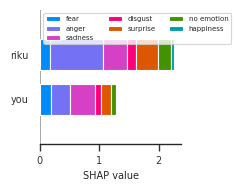

Axes(0.221514,0.257417;0.706486x0.670583)
   Names  Metric
0   Riku    0.16
1    Wei    0.22
2  Huang    0.24
3    Tom    0.26
4   Shan    0.26


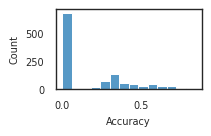

In [10]:
df_flips = evaluate('data/all.pkl', 10, 5, 'Riku')

The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!
The feature_perturbation option is now deprecated in favor of using the appropriate masker (maskers.Independent, or maskers.Impute)
The figure layout has changed to tight


['0  no . let me take a look ... it ’ s longer than my car .   I think it ’ s over five meters long . I can ’ t remember exactly . It has a maximum speed of over 200 kilometers an hour . '
 "0  Basically , you just can't drive .   Can I have another try ? "
 "4  Great . We can chat while enjoying a cup there .   Let's go ! "
 '0  No , I am ok , really .   Come on man ! I even got dope and acid ! Try some ! '
 " That's excellent . How have you managed that ? "]
Riku 0  no . let me take a look ... it ’ s longer than my car .   I think it ’ s over five meters long . I can ’ t remember exactly . It has a maximum speed of over 200 kilometers an hour . 
Riku 0  Basically , you just can't drive .   Can I have another try ? 
Riku 4  Great . We can chat while enjoying a cup there .   Let's go ! 
Riku 0  No , I am ok , really .   Come on man ! I even got dope and acid ! Try some ! 
Riku  That's excellent . How have you managed that ? 
Riku 0  Why don't we go for one now ?   Great . We can chat w

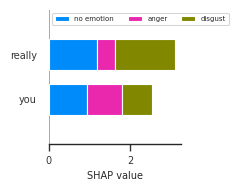

Axes(0.264639,0.257417;0.663361x0.670583)
  Names  Metric
0  Riku     1.0


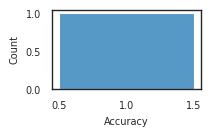

In [6]:
df_flips = evaluate('data/noone.pkl', 10, 5, 'Riku')

In [112]:
tex =  df_flips[:5].to_latex(
    index=False,
    float_format="{:.2f}".format,
    caption='hello')
print(tex)

\begin{table}
\caption{hello}
\begin{tabular}{lr}
\toprule
Names & Metric \\
\midrule
Riku & 0.16 \\
Wei & 0.22 \\
Huang & 0.24 \\
Tom & 0.26 \\
Chang & 0.26 \\
\bottomrule
\end{tabular}
\end{table}

